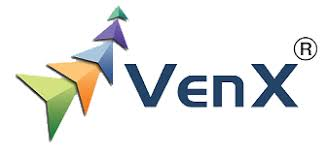

# **OBJECTIVE**




 1. Build a Regression-Based Sales Prediction Model

- Use historical features (month, weekday, events, festivals, auspicious days, ads, product group, etc.) to predict future AMOUNT .

- Train the model on data to learn how day-level factors influence sales.

2. Create a Reusable Forecasting Function

- Accept a future calendar (with event info but no sales values).

- Automatically assign day-type groups and generate predicted sales for each date.

# Libraries

In [948]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Importing dataset

In [949]:
# mount to the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [950]:
# dataset path
dataset_path = '/content/gdrive/MyDrive/venx1(Sheet1).csv'

dataset = pd.read_csv(dataset_path)
print("Dataset loaded successfully!")

df=dataset.copy() # Future reference securing the original dataset

Dataset loaded successfully!


# Data summary

## Data set glimpse

In [951]:
# checking the first five rows of dataset
df.head(5)

,Branch,BillDate,ProductGroup,PaperAdd,AuspiciousDay,FestivalName,StoreEvent,WeekDay,QTY,AMOUNT
0,VenX It Solutions,1-Jan-23,Accessories,NaN,NaN,SANKRANTI MAJOR,NaN,1-Sunday,2,23924.000
1,VenX It Solutions,1-Jan-23,Handlooms,NaN,NaN,SANKRANTI MAJOR,NaN,1-Sunday,52,24567.000
2,VenX It Solutions,1-Jan-23,ReadyMade,NaN,NaN,SANKRANTI MAJOR,NaN,1-Sunday,100,1054777.398
3,VenX It Solutions,1-Jan-23,Textiles,NaN,NaN,SANKRANTI MAJOR,NaN,1-Sunday,522,567547.000
4,VenX It Solutions,2-Jan-23,Accessories,YES,NaN,SANKRANTI MAJOR,PONGAL SALE,2-Monday,5,6763.100


In [952]:
# checking last five rows
df.tail(5)

,Branch,BillDate,ProductGroup,PaperAdd,AuspiciousDay,FestivalName,StoreEvent,WeekDay,QTY,AMOUNT
332,VenX It Solutions,30-Aug-24,ReadyMade,NaN,NaN,SRAVANAM,NaN,6-Friday,50,858585.000
333,VenX It Solutions,30-Aug-24,Textiles,NaN,NaN,SRAVANAM,NaN,6-Friday,45,858874.000
334,VenX It Solutions,31-Aug-24,Handlooms,NaN,NaN,SRAVANAM,NaN,7-Saturday,59,162784.697
335,VenX It Solutions,31-Aug-24,ReadyMade,NaN,NaN,SRAVANAM,NaN,7-Saturday,25,6865856.000
336,VenX It Solutions,31-Aug-24,Textiles,NaN,NaN,SRAVANAM,NaN,7-Saturday,41,578578.000


## Shape of the dataset

In [953]:
#shape of the data set
df.shape

(337, 10)

- Data set has
  - rows = 337
  - columns = 10
- Dataset is very small leading to
  -a high risk of the data not accurately representing the broader population, which can lead to models that don't generalize well to new, unseen data (overfitting).

## Data type

In [954]:
# checking data type
df.dtypes

,0
Branch,object
BillDate,object
ProductGroup,object
PaperAdd,object
AuspiciousDay,object
FestivalName,object
StoreEvent,object
WeekDay,object
QTY,int64
AMOUNT,float64


- The column BILLDATE is read as object type hence converting it to datetime type to extract date time trends

In [955]:
df['BillDate'] = pd.to_datetime(df['BillDate'], format='%d-%b-%y')
print("Data type of 'BillDate' column changed to datetime.")
df.dtypes

Data type of 'BillDate' column changed to datetime.


,0
Branch,object
BillDate,datetime64[ns]
ProductGroup,object
PaperAdd,object
AuspiciousDay,object
FestivalName,object
StoreEvent,object
WeekDay,object
QTY,int64
AMOUNT,float64


## Duplicates

In [956]:
# checking for data duplicates
duplicates =df.duplicated().sum()
print("Duplicates present in dataset :",duplicates)

Duplicates present in dataset : 0


## Missing Values and Treatment

In [957]:
#checking missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Branch             0
BillDate           0
ProductGroup       0
PaperAdd         298
AuspiciousDay    262
FestivalName     189
StoreEvent       237
WeekDay            0
QTY                0
AMOUNT             0
dtype: int64


- There are missing values presnt in paperadd , auspicious day ,festival name,store event - Missingness in columns carry information


- Considering the size of the dataset being very limited
proceeding with the assumption

    - **PaperAdd** → NaN means “**No paper advertisement was done that day.”**

  - **Auspicious Day** → NaN means “**It is NOT an auspicious day**.”

  - **Festival Name** → NaN means **“No festival on that date.”**

  - **StoreEvent** → NaN means **“No store event conducted that day".**

In [958]:
# Basing on assumption replaced the NAN values.
df.fillna({
    'PaperAdd': 'NO',
    'StoreEvent': 'NO_Event',
    'AuspiciousDay': 'NO',
    'FestivalName': 'NO_Festival'
}, inplace=True)
print("NAN replaced successfully")

NAN replaced successfully


In [959]:
# missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Branch           0
BillDate         0
ProductGroup     0
PaperAdd         0
AuspiciousDay    0
FestivalName     0
StoreEvent       0
WeekDay          0
QTY              0
AMOUNT           0
dtype: int64


## Unique values of columns

In [960]:
# unique values
unique_values = df.nunique()
print("Unique values in each column:")
print(unique_values)

Unique values in each column:
Branch             1
BillDate          93
ProductGroup       4
PaperAdd           2
AuspiciousDay      2
FestivalName       4
StoreEvent         5
WeekDay            7
QTY              204
AMOUNT           332
dtype: int64


In [961]:
# info of unique values
print("Dataset carries information of single branch - VenX")
print("---"*20)
print("ProductGroup column:")
print(df['ProductGroup'].unique())
print("---"*20)
print("FestivalName column:")
print(df['FestivalName'].unique())
print("---"*20)
print("StoreEvent column:")
print(df['StoreEvent'].unique())


Dataset carries information of single branch - VenX
------------------------------------------------------------
ProductGroup column:
['Accessories ' 'Handlooms' 'ReadyMade' 'Textiles']
------------------------------------------------------------
FestivalName column:
['SANKRANTI MAJOR' 'NO_Festival' 'VINAYAKA CHAVITHI' 'SRAVANAM']
------------------------------------------------------------
StoreEvent column:
['NO_Event' 'PONGAL SALE' 'UPTO 50% OFF ON HANDPICKED SAREE'
 'UPTO 20% OFF ON HANDPICKED SAREE' 'ASHADAM SALE']


## Statistical summary

In [962]:
# statistical summary - Numerical columns
df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
QTY,337.0,3.462878e+02,7.217669e+02,1.0,30.00,78.0000,280.0000,5988.0
AMOUNT,337.0,1.258742e+06,7.130233e+06,-8530.3,54875.85,188149.2511,707511.4201,85678578.0


- Max = 85,678,578 — an extremely large value compared to the rest; this is almost certainly an outlier or maybe entered incorrectly

- Min = -8,530.3 — negative sales. That deserves attention likely returns/refunds or a data-entry error

# Handling the Billdate column and Weekday column

- BILLDATE

In [963]:
# creating columns for analysis date , month, week , day ,is weekend or not
# analysis columns
df['Day'] = df['BillDate'].dt.day
df['Month'] = df['BillDate'].dt.month
df['Year'] = df['BillDate'].dt.year


# extract your CSV-based weekday numbering (1=Sun, 7=Sat)
df['WeekDayNum'] = df['WeekDay'].str.split('-').str[0].astype(int)

# weekend based on your store format
df['IsWeekend'] = df['WeekDayNum'].isin([1,7]).astype(int)



In [964]:
print("Unique values in 'Year' column:")
print(df['Year'].unique())

Unique values in 'Year' column:
[2023 2024]


- After treating the "Billdate" column the information in "Weekday" column is captured hence droping the weekday column as it has numeric and text formate in same row.


In [965]:
# dropping weekday column
df.drop('WeekDay', axis=1, inplace=True)
print("The WeekDay column has been dropped successfully.")

The WeekDay column has been dropped successfully.


# Exploratory Data Analysis

In [966]:
# list of column names
column_names = df.columns.tolist()
print(column_names)

['Branch', 'BillDate', 'ProductGroup', 'PaperAdd', 'AuspiciousDay', 'FestivalName', 'StoreEvent', 'QTY', 'AMOUNT', 'Day', 'Month', 'Year', 'WeekDayNum', 'IsWeekend']


## Univariate analysis

### Category wise sales distribution of products

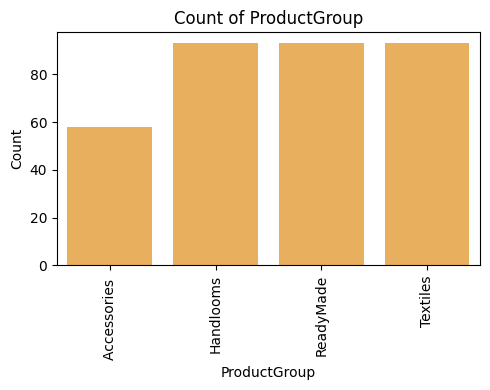

In [967]:
# visualizing the count of productgroup
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='ProductGroup', color='#FFB347') # Using a hex code for pastel orange
plt.title('Count of ProductGroup')
plt.xlabel('ProductGroup')
plt.ylabel('Count')
plt.xticks(rotation=90) # Rotate x-axis labels
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

- Accessories are least sold group compared to the others.

### Paperadd - frequency of ads being used


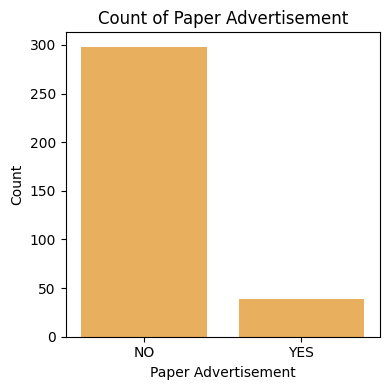

In [968]:
# visualizing the count of PaperAdd
plt.figure(figsize=(4, 4))
sns.countplot(data=df, x='PaperAdd', color='#FFB347') # Using a hex code for pastel orange
plt.title('Count of Paper Advertisement')
plt.xlabel('Paper Advertisement')
plt.ylabel('Count')
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

- most times paperads are not given.


### Festival name - which festival hold most portion in dataset


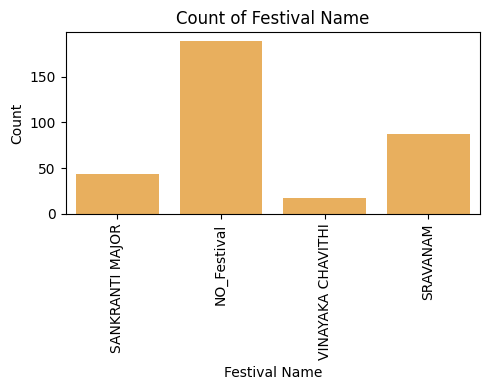

In [969]:
#visualizing count plot for festival name
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='FestivalName', color='#FFB347')
plt.title('Count of Festival Name')
plt.xlabel('Festival Name')
plt.ylabel('Count')
plt.xticks(rotation=90) # Rotate x-axis labels
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()


- Most part of dataset has no fesival and general day sales happening
- Sravanam leading the festival sales compared to sankranti and vinayaka chavithi.

### Distribution of QTY sold

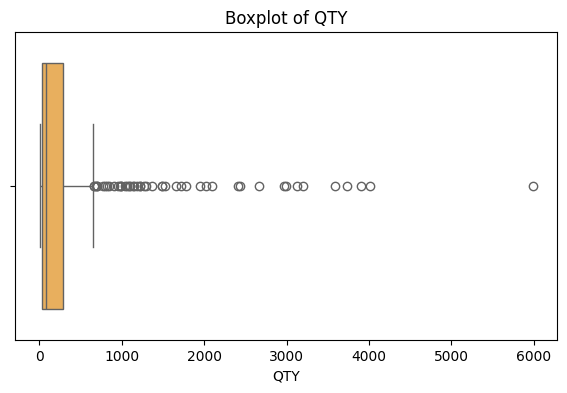

In [970]:
# boxplot for QTY to detect outliers
plt.figure(figsize=(7, 4))
sns.boxplot(data=df, x='QTY', color='#FFB347')
plt.title('Boxplot of QTY')
plt.xlabel('QTY')
plt.show()


- QTY is strongly right-skewed
- Most transactions involve relatively small quantities, while a small number of transactions have very large quantities.
-These high-QTY cases appear as outliers and should be investigated they could be bulk sales or error in recording.

### Distribution of Amount of sale


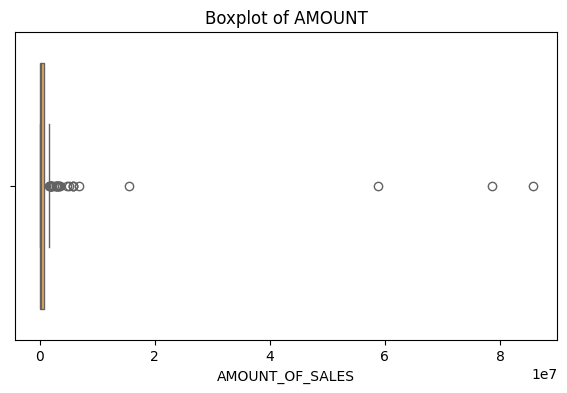

In [971]:
# boxplot to visualize sales
plt.figure(figsize=(7, 4))
sns.boxplot(data=df, x='AMOUNT', color='#FFB347')
plt.title('Boxplot of AMOUNT')
plt.xlabel('AMOUNT_OF_SALES')
plt.show()


- The boxplot shows a highly right-skewed distribution
- Most values clustered at the lower end.
- Several extremely high outliers stretch the scale, indicating possible anomalies or rare large transactions.

### Year - count of which year has more sales happening

Text(0, 0.5, 'Count')

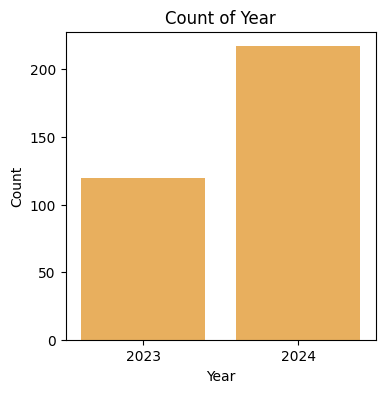

In [972]:
# count plot for the column year
plt.figure(figsize=(4, 4))
sns.countplot(data=df, x='Year', color='#FFB347')
plt.title('Count of Year')
plt.xlabel('Year')
plt.ylabel('Count')

- The dataset shows the year 2024 has more recorded sales happening.

### Month - which month has dominated the sales

In [973]:
# unique values in the month column
df['Month'].unique()

array([1, 7, 8], dtype=int32)

Text(0, 0.5, 'Count')

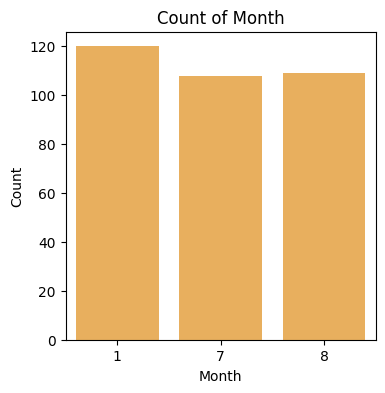

In [974]:
# count plot for  month column
plt.figure(figsize=(4, 4))
sns.countplot(data=df, x='Month', color='#FFB347')
plt.title('Count of Month')
plt.xlabel('Month')
plt.ylabel('Count')

- January [1] has recored more transactions happening compared to the other two months.

### Isweekend - visualizing count of transcations happening in weekday /weekend

Text(0, 0.5, 'Count')

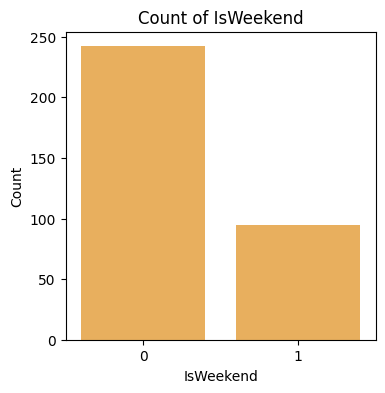

In [975]:
# visualizing countplot of isweekend
plt.figure(figsize=(4, 4))
sns.countplot(data=df, x='IsWeekend', color='#FFB347')
plt.title('Count of IsWeekend')
plt.xlabel('IsWeekend')
plt.ylabel('Count')

- There are more transactions recored on non-weekend days compared to weekends

## Bivariate analysis

### QTY vs AMOUNT
- Visualize the relation between QTY and amount column.

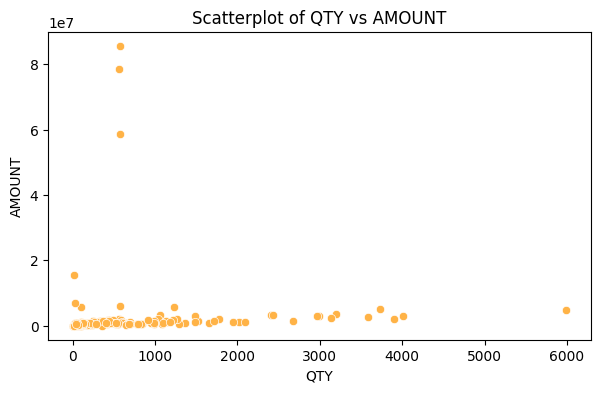

In [976]:
# scatterplot for qty and amount
plt.figure(figsize=(7, 4))
sns.scatterplot(data=df, x='QTY', y='AMOUNT', color='#FFB347')
plt.title('Scatterplot of QTY vs AMOUNT')
plt.xlabel('QTY')
plt.ylabel('AMOUNT')
plt.show()

- The points are widely scattered — QTY is not tightly correlated with AMOUNT
- massive outliers in AMOUNT
- Most points cluster in:

    - QTY < 1500

    - AMOUNT < ₹2L

    - This means most transactions are small-quantity and small-value.
- QTY is 2000–6000 but AMOUNT is relatively low maybe outof bulk low-value products

### Month vs QTY and amount
- Visualize any trend of QTY being affected by month showing seasonality

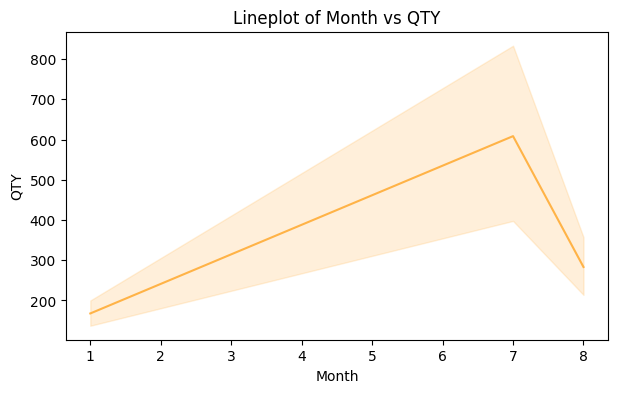

In [977]:
# lineplot of month vs QTY
plt.figure(figsize=(7, 4))
sns.lineplot(data=df, x='Month', y='QTY', color='#FFB347')
plt.title('Lineplot of Month vs QTY')
plt.xlabel('Month')
plt.ylabel('QTY')
plt.show()

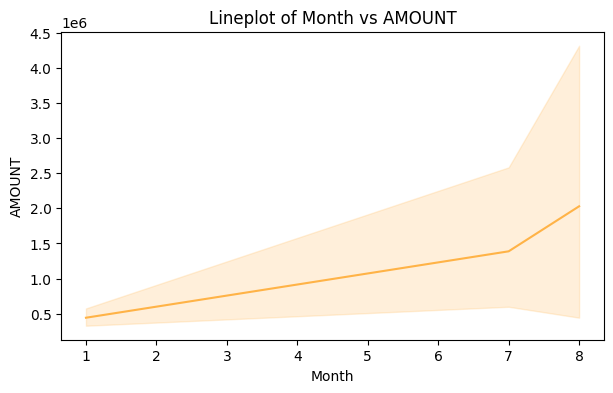

In [978]:
# lineplot of month vs amount
plt.figure(figsize=(7, 4))
sns.lineplot(data=df, x='Month', y='AMOUNT', color='#FFB347')
plt.title('Lineplot of Month vs AMOUNT')
plt.xlabel('Month')
plt.ylabel('AMOUNT')
plt.show()

- steady increase of sale qty from JAN to JULY
- Decline in Aug.
- There is increasing trend in sales amount too flowing the pattern of qty but there is increasing trend in amount even for declined qty of sale.


### Day vs QTY and amount
- visualizing daily trends

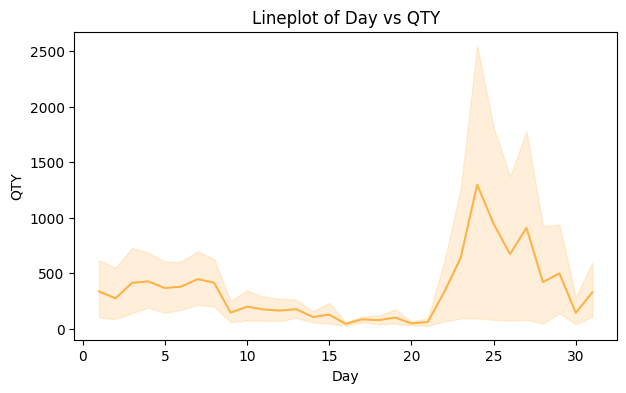

In [979]:
# visualising using line plot for day vs qty
plt.figure(figsize=(7, 4))
sns.lineplot(data=df, x='Day', y='QTY', color='#FFB347')
plt.title('Lineplot of Day vs QTY')
plt.xlabel('Day')
plt.ylabel('QTY')
plt.show()


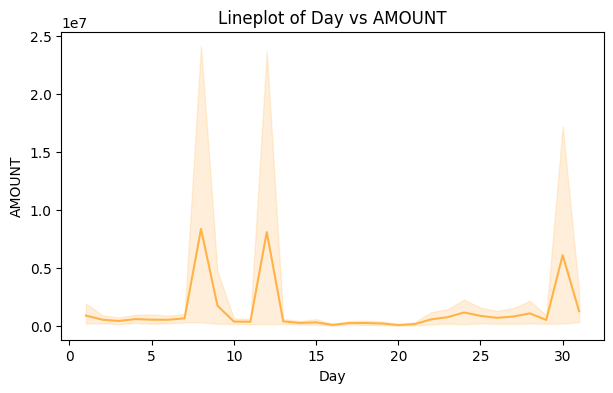

In [980]:
#line plot for day vs AMOUNT
plt.figure(figsize=(7, 4))
sns.lineplot(data=df, x='Day', y='AMOUNT', color='#FFB347')
plt.title('Lineplot of Day vs AMOUNT')
plt.xlabel('Day')
plt.ylabel('AMOUNT')
plt.show()

- QTY (quantity) shows moderate daily fluctuations with a major spike around Day 24–26.

- AMOUNT, however, shows extremely high spikes on Day 8–9, Day 12–13, and Day 30, even though QTY remains low or moderate on those day

### ProductGroup vs QTY
- Top performing category

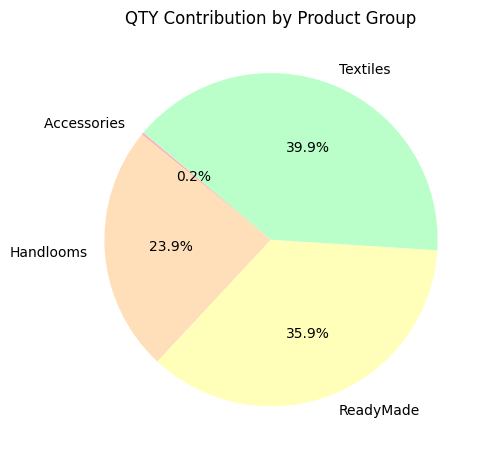

In [981]:
# aggregate QTY by ProductGroup
qty_by_group = df.groupby('ProductGroup')['QTY'].sum()

# pastel color palette
pastel_colors = [
    "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF",
    "#E3BAFF", "#FFBADA", "#C2FFFA"
]

plt.figure(figsize=(5,5))
plt.pie(
    qty_by_group,
    labels=qty_by_group.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=pastel_colors[:len(qty_by_group)]  # adjust to number of groups
)
plt.title('QTY Contribution by Product Group')
plt.tight_layout()
plt.show()

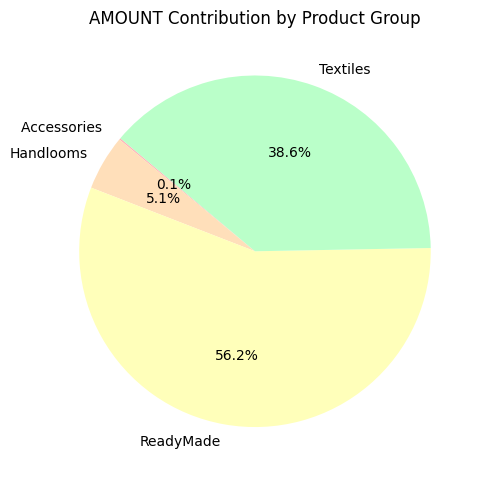

In [982]:
# aggregate AMOUNT by ProductGroup
amount_by_group = df.groupby('ProductGroup')['AMOUNT'].sum()

# pastel color palette
pastel_colors = [
    "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF",
    "#E3BAFF", "#FFBADA", "#C2FFFA"
]

plt.figure(figsize=(5,5))
plt.pie(
    amount_by_group,
    labels=amount_by_group.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=pastel_colors[:len(amount_by_group)]
)
plt.title('AMOUNT Contribution by Product Group')
plt.tight_layout()
plt.show()

- In terms of quantity sold textiles dominate the cchart
- In terms of revenue made Readymades are generating more revenue even when there qty share ~ 36% but revenue share being ~56%

### StoreEvent vs QTY
- visualize if event has uplifed the sale QTY

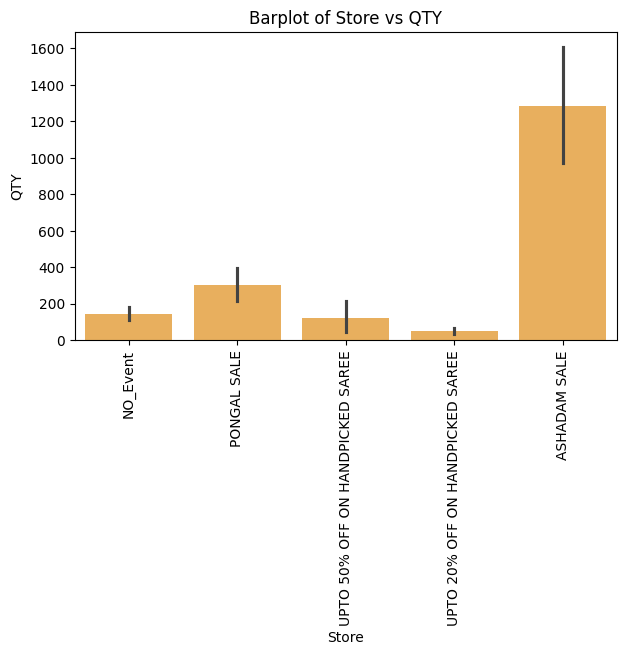

In [983]:
# barplot for storeevent vs QTY
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x='StoreEvent', y='QTY', color='#FFB347')
plt.title('Barplot of Store vs QTY')
plt.xlabel('Store')
plt.xticks(rotation=90)
plt.ylabel('QTY')
plt.show()

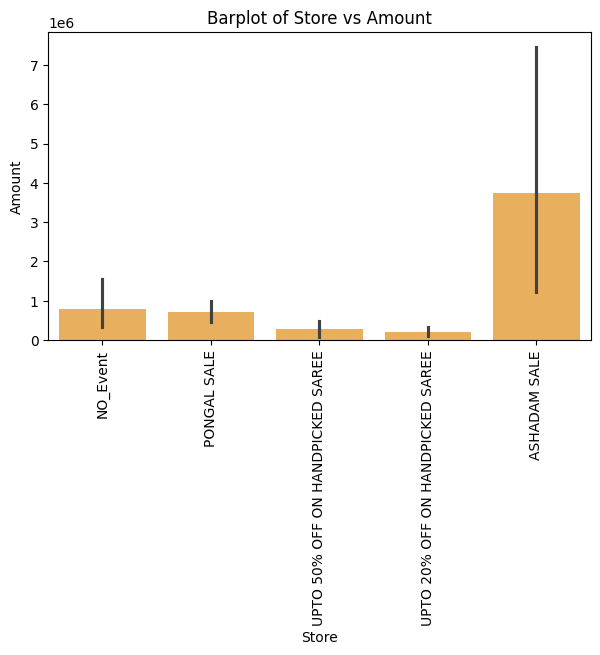

In [984]:
# barplot for storeevent vs AmOUnt
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x='StoreEvent', y='AMOUNT', color='#FFB347')
plt.title('Barplot of Store vs Amount')
plt.xlabel('Store')
plt.xticks(rotation=90)
plt.ylabel('Amount')
plt.show()

- ASHADAM SALE → Highest uplift
  - ASHADAM SALE created a strong sales volume spike, followed by PONGAL SALE.
- Lower discount events did not uplift QTY significantly
- ASHADAM SALE → Huge revenue spike

  - Indicates high-value purchases + high volume.
- Discount-based events (20% & 50%) did not strongly push revenue

### AuspiciousDay vs QTY
- auspicious day impact on the sale qty

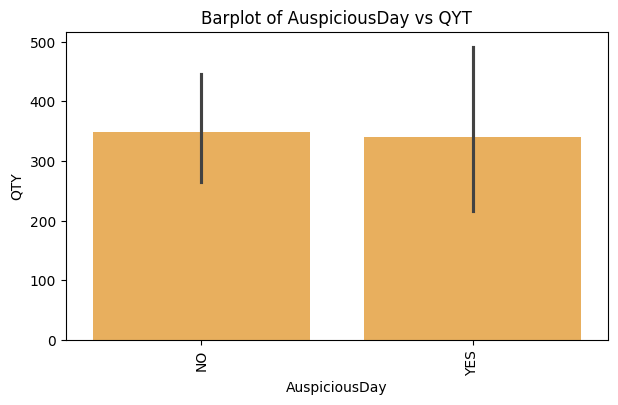

In [985]:
# barplot for auspiciousday vs QTY
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x='AuspiciousDay', y='QTY', color='#FFB347')
plt.title('Barplot of AuspiciousDay vs QYT')
plt.xlabel('AuspiciousDay')
plt.xticks(rotation=90)
plt.ylabel('QTY')
plt.show()

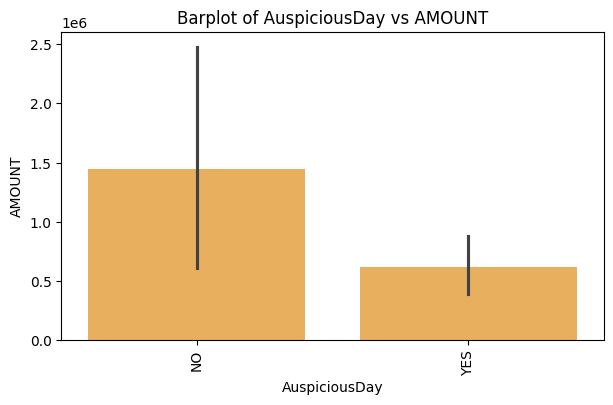

In [986]:
# barplot for auspiciousday vs Amount
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x='AuspiciousDay', y='AMOUNT', color='#FFB347')
plt.title('Barplot of AuspiciousDay vs AMOUNT')
plt.xlabel('AuspiciousDay')
plt.xticks(rotation=90)
plt.ylabel('AMOUNT')
plt.show()

- Quantity sold is unaffected by whether the day is auspicious.
- The bars are nearly the same height  No significant difference in quantity sold
- The average AMOUNT is much higher on non-auspicious days ("NO") than on auspicious days ("YES")
- Bar [|] for no is very big indicating uncertainity in the data showing more variations in the values.

### FestivalName vs QTY
- festival-driven peaks in sale of qty

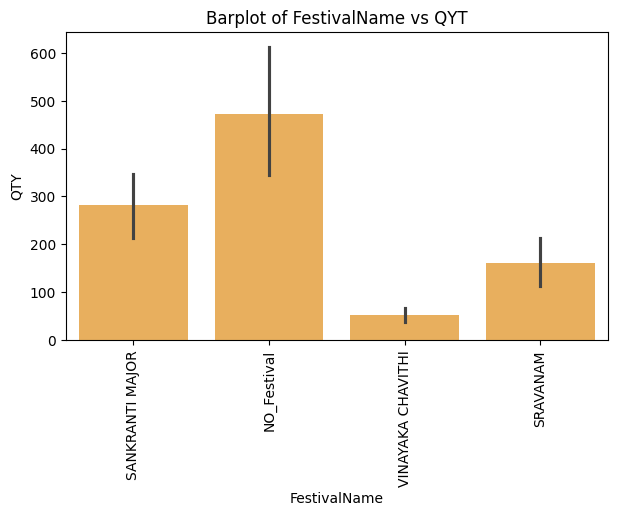

In [987]:
# barplot for FestivalName vs QTY
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x='FestivalName', y='QTY', color='#FFB347')
plt.title('Barplot of FestivalName vs QYT')
plt.xlabel('FestivalName')
plt.xticks(rotation=90)
plt.ylabel('QTY')
plt.show()

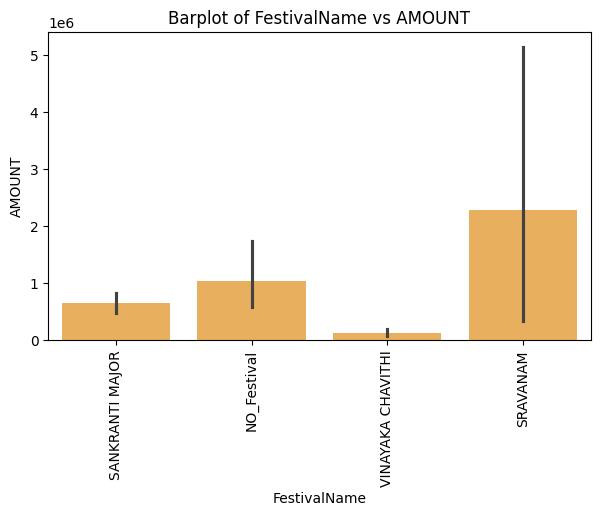

In [988]:
# barplot for FestivalNamevs Amount
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x='FestivalName', y='AMOUNT', color='#FFB347')
plt.title('Barplot of FestivalName vs AMOUNT')
plt.xlabel('FestivalName')
plt.xticks(rotation=90)
plt.ylabel('AMOUNT')
plt.show()

- Quantity sold on NO_FESTIVAL days in quite large yet The Revenue generated is very less .
- There is huge revenue generated during sravanam with lot of spread in data with long bar line .

### IsWeekend vs QTY
- weekend vs weekday performance in sale of no. of QTY

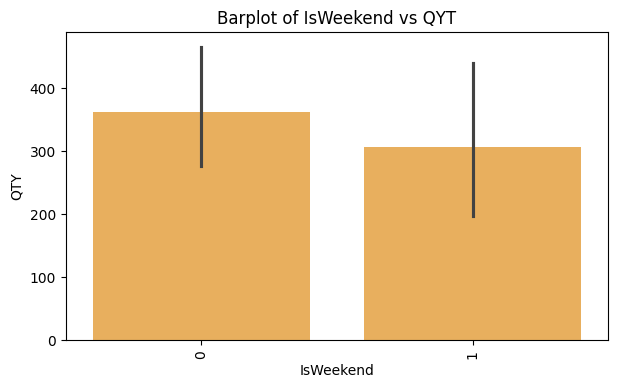

In [989]:
# barplot for IsWeekend vs QTY
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x='IsWeekend', y='QTY', color='#FFB347')
plt.title('Barplot of IsWeekend vs QYT')
plt.xlabel('IsWeekend')
plt.xticks(rotation=90)
plt.ylabel('QTY')
plt.show()

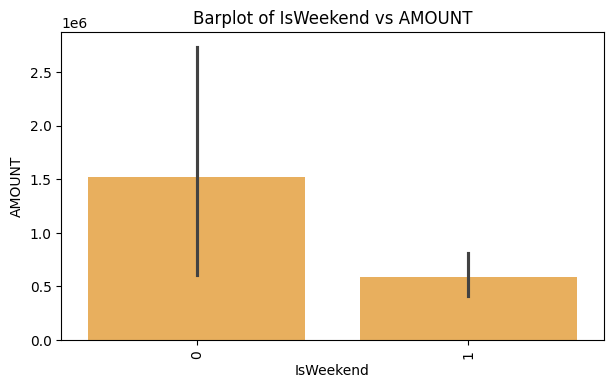

In [990]:
# barplot for IsWeekend Amount
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x='IsWeekend', y='AMOUNT', color='#FFB347')
plt.title('Barplot of IsWeekend vs AMOUNT')
plt.xlabel('IsWeekend')
plt.xticks(rotation=90)
plt.ylabel('AMOUNT')
plt.show()

- The quantity sold on week days is more compared to weekend
- Revenue generated on week days is also more with variablity in values.
- Though the quanty sold on weekends is almost similar to weekdays but revenue generated is very low.

### WeekDayNum vs QTY
- weekday consumption pattern

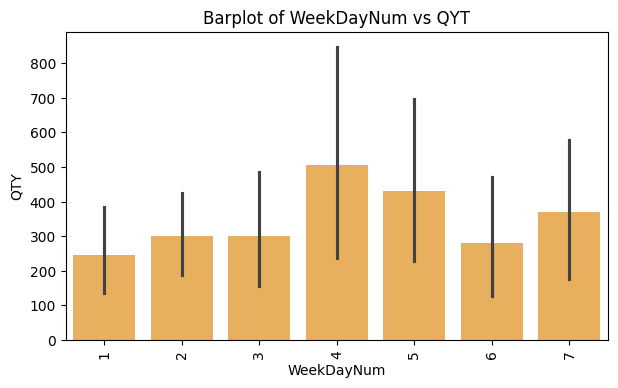

In [991]:
# barplot for WeekDayNum vs QTY
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x='WeekDayNum', y='QTY', color='#FFB347')
plt.title('Barplot of WeekDayNum vs QYT')
plt.xlabel('WeekDayNum')
plt.xticks(rotation=90)
plt.ylabel('QTY')
plt.show()

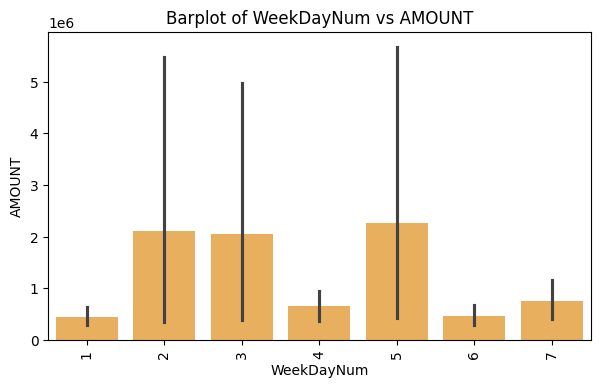

In [992]:
# barplot for WeekDayNum vs Amount
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x='WeekDayNum', y='AMOUNT', color='#FFB347')
plt.title('Barplot of WeekDayNum vs AMOUNT')
plt.xlabel('WeekDayNum')
plt.xticks(rotation=90)
plt.ylabel('AMOUNT')
plt.show()

- Wednesday - 4 records high quantity of sales compared to other days of the week but show lowest revenue generate.
- Thursday of the week generated highest revenue with variable values and 2nd highest in quantity sold.

### PaperAdd vs QTY
- advertising effect on sale




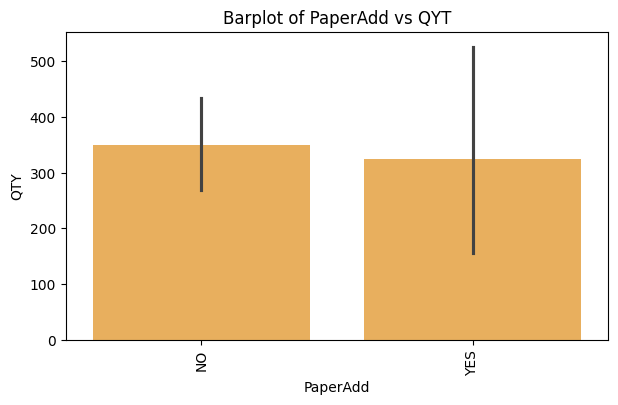

In [993]:
# barplot for PaperAdd vs QTY
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x='PaperAdd', y='QTY', color='#FFB347')
plt.title('Barplot of PaperAdd vs QYT')
plt.xlabel('PaperAdd')
plt.xticks(rotation=90)
plt.ylabel('QTY')
plt.show()

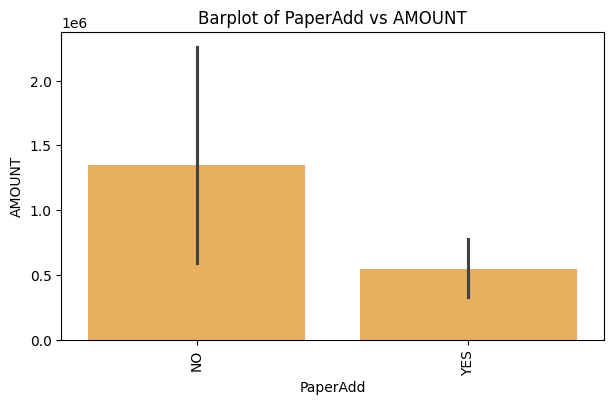

In [994]:
# barplot for PaperAdd vs Amount
plt.figure(figsize=(7, 4))
sns.barplot(data=df, x='PaperAdd', y='AMOUNT', color='#FFB347')
plt.title('Barplot of PaperAdd vs AMOUNT')
plt.xlabel('PaperAdd')
plt.xticks(rotation=90)
plt.ylabel('AMOUNT')
plt.show()

- The QTY sold is not very much influenced by the paperadd
- The revenue generated is higher without ad with huge bar line indicating variability.

## Multivariate analysis


### Month × ProductGroup × QTY
→ seasonal category trends

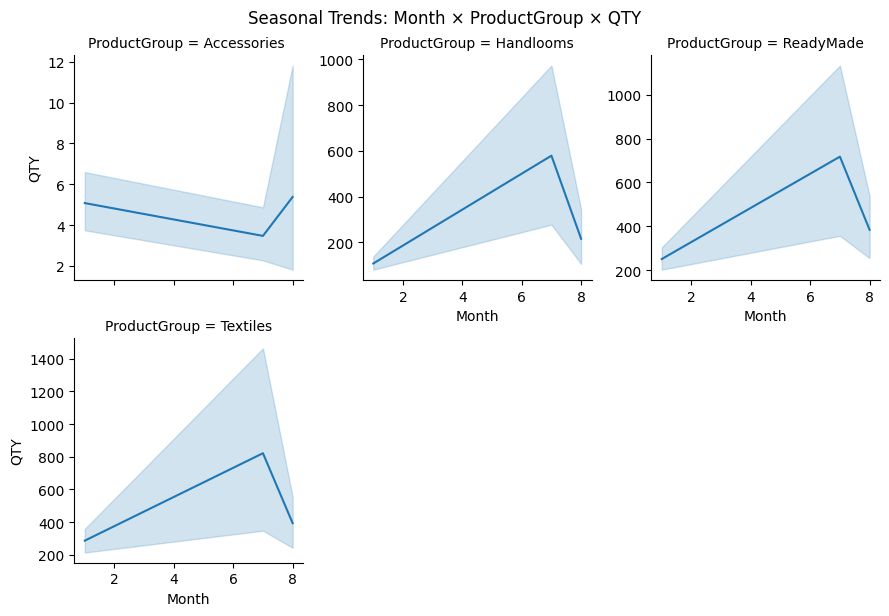

In [995]:
# facet line plot to check whether particular category of product sale qyt is effected by the month showing seasonality.
g = sns.FacetGrid(df, col="ProductGroup", col_wrap=3, height=3, sharey=False)
g.map_dataframe(sns.lineplot, x="Month", y="QTY")
g.set_axis_labels("Month", "QTY")
g.fig.suptitle("Seasonal Trends: Month × ProductGroup × QTY", y=1.02)
plt.show()

- Only Accessories show a declining trend in the qty sold
- The other categories show a peak around 7th month showing highest quantity sold

### FestivalName × ProductGroup × AMOUNT
→ festival-wise category performance

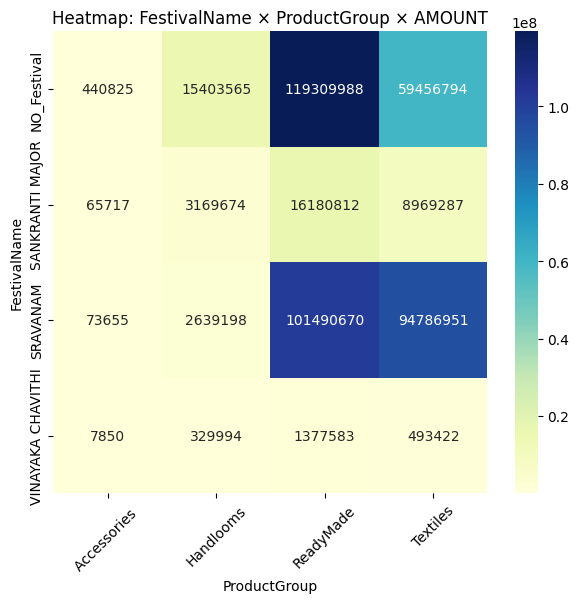

In [996]:
#heatmap to visualise how much revenue is generate by each category during each festival
#  pivot table: sum of AMOUNT for each Festival × ProductGroup
pivot_df = df.pivot_table(
    index='FestivalName',
    columns='ProductGroup',
    values='AMOUNT',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(7, 6))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Heatmap: FestivalName × ProductGroup × AMOUNT")
plt.xlabel("ProductGroup")
plt.ylabel("FestivalName")
plt.xticks(rotation=45)
plt.show()

- "NO_Festival" Drives Highest Overall Revenue
- "ReadyMade" is the Top Revenue Generator
- Revenue Spike in "ReadyMade" during Festivals: The "SRAVANAM"

### StoreEvent × Weekend × QTY
→ event impact on weekend sales

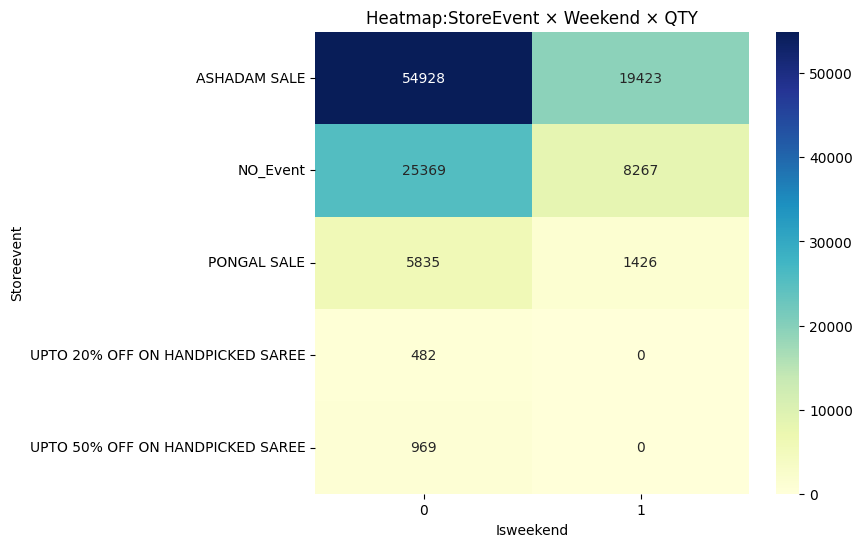

In [997]:
pivot_df = df.pivot_table(
    index='StoreEvent',
    columns='IsWeekend',
    values='QTY',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(7, 6))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Heatmap:StoreEvent × Weekend × QTY")
plt.xlabel("Isweekend")
plt.ylabel("Storeevent")
plt.show()

- "ASHADAM SALE" event is by far the largest contributor to sales quantity
- For two biggest sales categories ("ASHADAM SALE" and "NO_Event"), sales quantity is much higher during weekdays.

### AuspiciousDay × FestivalName × AMOUNT
→ festival vs auspicious contribution

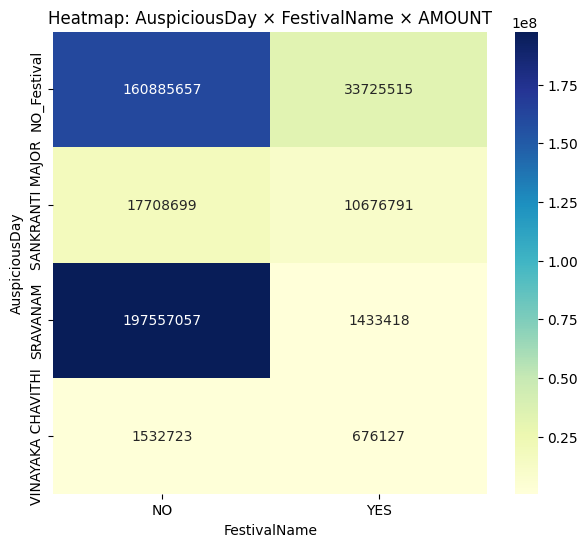

In [998]:
# Heatmap to visualise how much revenue is generate on particular festival and auspicious days
pivot_df = df.pivot_table(
    columns='AuspiciousDay',
    index='FestivalName',
    values='AMOUNT',
    aggfunc='sum',
    fill_value=0
)
plt.figure(figsize=(7, 6))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Heatmap: AuspiciousDay × FestivalName × AMOUNT")
plt.ylabel("AuspiciousDay")
plt.xlabel("FestivalName")
plt.show()


- Revenue is Dominated by Non-Auspicious Days
- The combination of the "SRAVANAM" festival and a non-auspicious day (NO) results in the single highest revenue cel


### ProductGroup × PaperAdd × QTY
→ ad-driven category improvement

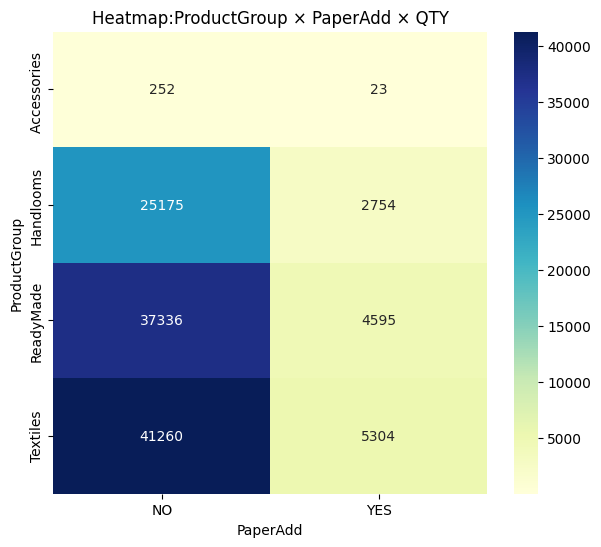

In [999]:
# heatmap showing if paperadd has influes any category of product in quantity sold
pivot_df = df.pivot_table(
    columns='PaperAdd',
    index='ProductGroup',
    values='QTY',
    aggfunc='sum',
    fill_value=0
)
plt.figure(figsize=(7, 6))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Heatmap:ProductGroup × PaperAdd × QTY")
plt.xlabel("PaperAdd")
plt.ylabel("ProductGroup")
plt.show()

- Highest Sales Quantity Without Paper Ads
- High Impact for "Textiles" from Paper Ads
- Accessories are Least Affected

### Month × WeekDayNum × QTY
→ weekday behavior across months

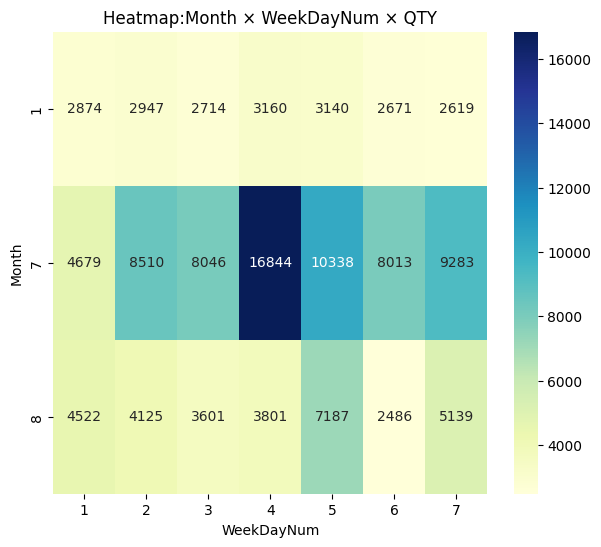

In [1000]:
# heatmap showing weekdaynum of a month is influencing the QTY
pivot_df = df.pivot_table(
    columns='WeekDayNum',
    index='Month',
    values='QTY',
    aggfunc='sum',
    fill_value=0
)
plt.figure(figsize=(7, 6))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Heatmap:Month × WeekDayNum × QTY")
plt.xlabel("WeekDayNum")
plt.ylabel("Month")
plt.show()


- Month 7 (July) is the Peak Sales Period
-Month 1 exhibits the most consistent sales quantity across all seven days of the week
- Month 8 (August) shows the highest day-to-day variability compared to the other months

# SUMMARY - Exploratory data analysis




---
- **Overall Sales Behavior**
  - QTY and AMOUNT are weakly correlated, with AMOUNT showing strong outliers.

- **Monthly Trends**
  - Sales quantity rises steadily from Jan to July, then drops in August.
  - Revenue follows the same pattern but spikes even on months with lower QTY.

- **Daily & Date-Level Patterns**

  - QTY peaks around days 24–26.

  - AMOUNT spikes sharply on days 8–9, 12–13, and 30 regardless of QTY

- **Product Categorys**

  - Textiles lead in QTY sold - ReadyMade leads revenue generation.

  - Accessories show decline, while other categories peak in Month 7.
- **Event & Promotion Impact**

  - ASHADAM SALE produces the highest uplift in both QTY and AMOUNT.

  - Discount events (20%, 50%) show minimal impact on sales.
- **Festival Effects**

  - NO_FESTIVAL days contribute highest QTY overall.

  - SRAVANAM drives major revenue spikes with high variability.
- **Auspicious vs Non-Auspicious Days**

  - QTY remains nearly unchanged between auspicious and non-auspicious days.

  - Revenue is significantly higher on non-auspicious days.
- **Weekday Patterns**

  - Wednesday shows high QTY but low revenue.

  - Thursday yields the highest revenue and strong QTY.

- **Weekend vs Weekday**

  - Major events see higher sales on weekdays than weekends.

  - Weekends do not dominate either QTY or revenue.

- **Paper Ads Impact**

  - QTY is mostly unaffected by Paper Ads.

  - Revenue is higher on non-ad days, except Textiles which benefit from ads.

  ---








# Outliers


 AMOUNT AND QTY
 - Not treating the outliers.
 - Considering bulk sales, festival-day spikes, store events, and unusual high-value purchases are real business events, not errors.
 - These are not “noise.” They are important signals


In [1001]:
df.head(10)

,Branch,BillDate,ProductGroup,PaperAdd,AuspiciousDay,FestivalName,StoreEvent,QTY,AMOUNT,Day,Month,Year,WeekDayNum,IsWeekend
0,VenX It Solutions,2023-01-01,Accessories,NO,NO,SANKRANTI MAJOR,NO_Event,2,2.392400e+04,1,1,2023,1,1
1,VenX It Solutions,2023-01-01,Handlooms,NO,NO,SANKRANTI MAJOR,NO_Event,52,2.456700e+04,1,1,2023,1,1
2,VenX It Solutions,2023-01-01,ReadyMade,NO,NO,SANKRANTI MAJOR,NO_Event,100,1.054777e+06,1,1,2023,1,1
3,VenX It Solutions,2023-01-01,Textiles,NO,NO,SANKRANTI MAJOR,NO_Event,522,5.675470e+05,1,1,2023,1,1
4,VenX It Solutions,2023-01-02,Accessories,YES,NO,SANKRANTI MAJOR,PONGAL SALE,5,6.763100e+03,2,1,2023,2,0
5,VenX It Solutions,2023-01-02,Handlooms,YES,NO,SANKRANTI MAJOR,PONGAL SALE,128,1.956005e+05,2,1,2023,2,0
6,VenX It Solutions,2023-01-02,ReadyMade,YES,NO,SANKRANTI MAJOR,PONGAL SALE,431,1.677286e+06,2,1,2023,2,0
7,VenX It Solutions,2023-01-02,Textiles,YES,NO,SANKRANTI MAJOR,PONGAL SALE,407,7.532702e+05,2,1,2023,2,0
8,VenX It Solutions,2023-01-03,Accessories,YES,NO,SANKRANTI MAJOR,PONGAL SALE,2,-8.530300e+03,3,1,2023,3,0
9,VenX It Solutions,2023-01-03,Handlooms,YES,NO,SANKRANTI MAJOR,PONGAL SALE,153,2.359153e+05,3,1,2023,3,0


# Feature Engineering

- Converting categorical columns into numeric form so the regression model can understand them
  ProductGroup

  - PaperAdd

  - AuspiciousDay

  -  FestivalName

   -   StoreEvent

## Feature encoding

- Choosing encoders based on:

  - very small dataset → avoid exploding features

  - categorical columns with no natural order

  - regression model ( likely to use tree-based or linear models)


---

1. ProductGroup → OneHotEncoder

- Few categories & important interaction

2. PaperAdd → Binary Encoding

- Only “YES/NO” → convert directly to 0/1.

3. AuspiciousDay → Binary Encoding

- Also “YES/NO” → convert to 0/1.

4. FestivalName → OneHotEncoder

- Only 4 festivals → OHE is stable , label encoder may sort in order.

5. StoreEvent → Binary Encoding

- Also “YES/NO” → convert to 0/1

- OneHotEncoder returns a NumPy array with no column names.
- To merge it back int original DataFrame, converted it into a proper pandas DataFrame

In [1002]:
# Binary Encoding (0/1)

df['PaperAdd'] = df['PaperAdd'].map({'YES': 1, 'NO': 0})
df['AuspiciousDay'] = df['AuspiciousDay'].map({'YES': 1, 'NO': 0})

# StoreEvent → convert to binary (YES = 1, NO_Event = 0)
df['StoreEvent'] = df['StoreEvent'].apply(lambda x: 0 if x == 'NO_Event' else 1)


# 2. One-Hot Encoding with dtype=int (0/1)

ohe_cols = ['ProductGroup', 'FestivalName']

df = pd.get_dummies(
    df,
    columns=ohe_cols,
    prefix=['PG', 'FN'],
    dtype=int
)



In [1003]:
df.head(5)

,Branch,BillDate,PaperAdd,AuspiciousDay,StoreEvent,QTY,AMOUNT,Day,Month,Year,WeekDayNum,IsWeekend,PG_Accessories,PG_Handlooms,PG_ReadyMade,PG_Textiles,FN_NO_Festival,FN_SANKRANTI MAJOR,FN_SRAVANAM,FN_VINAYAKA CHAVITHI
0,VenX It Solutions,2023-01-01,0,0,0,2,23924.000,1,1,2023,1,1,1,0,0,0,0,1,0,0
1,VenX It Solutions,2023-01-01,0,0,0,52,24567.000,1,1,2023,1,1,0,1,0,0,0,1,0,0
2,VenX It Solutions,2023-01-01,0,0,0,100,1054777.398,1,1,2023,1,1,0,0,1,0,0,1,0,0
3,VenX It Solutions,2023-01-01,0,0,0,522,567547.000,1,1,2023,1,1,0,0,0,1,0,1,0,0
4,VenX It Solutions,2023-01-02,1,0,1,5,6763.100,2,1,2023,2,0,1,0,0,0,0,1,0,0


- Considering the size of dataset skipping Feature selection and scaling , not to lose more information.

# **PART** **1**

- Build a Regression-Based Sales Prediction Model
Use historical features (month, weekday, events, festivals, auspicious days, ads, product group, etc.) to predict future AMOUNT .

- Train the model on data to learn how day-level factors influence sales.

# Modeling

- Dataset is extremely small (300+ rows)
- Branch → constant, no predictive value

- BillDate → raw date is not needed after extracting Day/Month/Year/Weekday

In [1004]:
# droping billdate and branch
df = df.drop(columns=["Branch", "BillDate"])
df.columns
df.columns = df.columns.str.strip()
print(df.columns)

Index(['PaperAdd', 'AuspiciousDay', 'StoreEvent', 'QTY', 'AMOUNT', 'Day',
       'Month', 'Year', 'WeekDayNum', 'IsWeekend', 'PG_Accessories',
       'PG_Handlooms', 'PG_ReadyMade', 'PG_Textiles', 'FN_NO_Festival',
       'FN_SANKRANTI MAJOR', 'FN_SRAVANAM', 'FN_VINAYAKA CHAVITHI'],
      dtype='object')


## Train and test split

In [1005]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [1006]:
# separating features and target
X = df.drop(columns=['AMOUNT'])
y = df['AMOUNT']

In [1007]:
# train and test split - traint validation test spliting can shrink data more so only test and val.

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Print the results
print("X_train shape:", X_train.shape)
print("X_val shape:",   X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:",   y_val.shape)

X_train shape: (269, 17)
X_val shape: (68, 17)
y_train shape: (269,)
y_val shape: (68,)


cross validation
 - Uses all rows for both training & validation (in rotation)
- Gives a more reliable accuracy estimate
- Helps prevent overfitting, which is very likely with small data

In [1008]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import numpy as np


## 1. Linear regression model with cross validation

In [1009]:
#  LINEAR REGRESSION + CV
lr = LinearRegression()
lr_cv_scores = cross_val_score(
    lr,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_absolute_error'
)

print("Linear Regression CV MAE:", -np.mean(lr_cv_scores))

Linear Regression CV MAE: 2632358.9784892434


## 2.desicion tree model

In [1010]:
# DECISION TREE + CV

dt = DecisionTreeRegressor(random_state=42)

dt_cv_scores = cross_val_score(
    dt,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_absolute_error'
)

print("Decision Tree CV MAE:", -np.mean(dt_cv_scores))

Decision Tree CV MAE: 1703749.124104955


In [1011]:
# FIT BOTH MODELS ON FULL TRAIN SET

lr.fit(X_train, y_train)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [1012]:
 #FINAL EVALUATION ON HELD-OUT 20% VALIDATION SET
from sklearn.metrics import mean_absolute_error
lr_val_pred = lr.predict(X_val)
dt_val_pred = dt.predict(X_val)
print("Linear Regression CV MAE:", -np.mean(lr_cv_scores))
print("Validation MAE (Linear Regression):", mean_absolute_error(y_val, lr_val_pred))
print("---"*25)
print("Decision Tree CV MAE:", -np.mean(dt_cv_scores))
print("Validation MAE (Decision Tree):", mean_absolute_error(y_val, dt_val_pred))


Linear Regression CV MAE: 2632358.9784892434
Validation MAE (Linear Regression): 1653288.4060231193
---------------------------------------------------------------------------
Decision Tree CV MAE: 1703749.124104955
Validation MAE (Decision Tree): 511191.08852733823


- Linear Regression still performs poorly.

- Decision Tree is MUCH better: only 5.1 lakh MAE.

Tree models performing better compared to linear regression as it is simplifing the model too much .

In [1013]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features': [None, 'sqrt', 'log2']
}

dt = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV MAE:", -grid_search.best_score_)


Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV MAE: 1036539.1262929784


In [1014]:
from sklearn.metrics import mean_absolute_error, r2_score

dt_best = grid_search.best_estimator_
y_pred_dt = dt_best.predict(X_val)
val_mae = mean_absolute_error(y_val, y_pred_dt)
val_r2 = r2_score(y_val, y_pred_dt)

print(f"Validation MAE: {val_mae:.2f}")
print(f"Validation R²: {val_r2:.4f}")

Validation MAE: 387263.27
Validation R²: -2.6030


- Decision Tree learned patterns from training data but fails to capture extremes in validation.
- Large outliers in y_val → MAE is robust, but R² is sensitive to squared error → can go very negative.

- The target variable has very high variance, even decent predictions can still result in negative R²

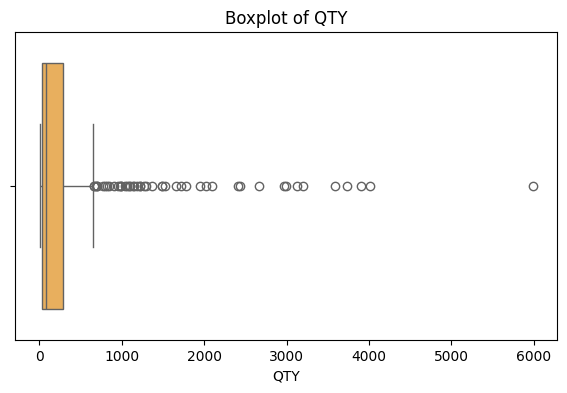

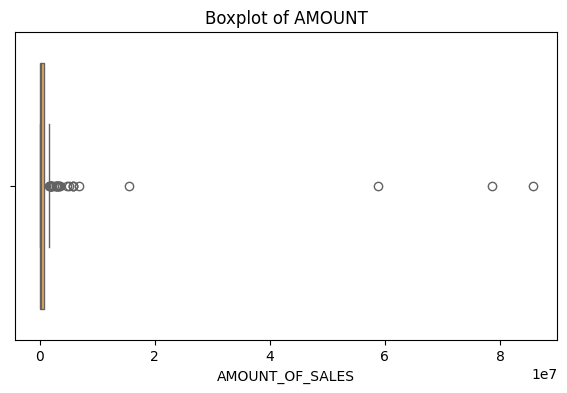

In [1015]:
# visualization of distibution of QTY and AMOUNT with box plot
# QTY
plt.figure(figsize=(7, 4))
sns.boxplot(data=df, x='QTY', color='#FFB347')
plt.title('Boxplot of QTY')
plt.xlabel('QTY')
plt.show()
#AMOUNT
plt.figure(figsize=(7, 4))
sns.boxplot(data=df, x='AMOUNT', color='#FFB347')
plt.title('Boxplot of AMOUNT')
plt.xlabel('AMOUNT_OF_SALES')
plt.show()

drop the extreme outliers. With such a small dataset (≈330 rows), extreme values can heavily skew the model, leading to very poor R² scores like the negative value observed. Removing them and rebuilding the model is reasonable.

In [1016]:
# Make a copy of the original DataFrame to work with
df_model = df.copy()

# --- Outlier removal for QTY ---
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for QTY
Q1_qty = df_model['QTY'].quantile(0.25)
Q3_qty = df_model['QTY'].quantile(0.75)

# Calculate the Interquartile Range (IQR) for QTY
IQR_qty = Q3_qty - Q1_qty

# Define the upper and lower bounds for outlier detection in QTY
lower_bound_qty = Q1_qty - 1.5 * IQR_qty
upper_bound_qty = Q3_qty + 1.5 * IQR_qty

# Get the shape of the DataFrame before QTY outlier removal
original_shape_qty = df_model.shape
print(f"Shape of DataFrame before QTY outlier removal: {original_shape_qty}")

# Filter out the outliers from the 'QTY' column
df_model = df_model[(df_model['QTY'] >= lower_bound_qty) & (df_model['QTY'] <= upper_bound_qty)]

# Get the shape of the DataFrame after QTY outlier removal
filtered_shape_qty = df_model.shape
print(f"Shape of DataFrame after QTY outlier removal: {filtered_shape_qty}")

# --- Outlier removal for AMOUNT ---
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for AMOUNT
Q1_amount = df_model['AMOUNT'].quantile(0.25)
Q3_amount = df_model['AMOUNT'].quantile(0.75)

# Calculate the Interquartile Range (IQR) for AMOUNT
IQR_amount = Q3_amount - Q1_amount

# Define the upper and lower bounds for outlier detection in AMOUNT
lower_bound_amount = Q1_amount - 1.5 * IQR_amount
upper_bound_amount = Q3_amount + 1.5 * IQR_amount

# Get the shape of the DataFrame before AMOUNT outlier removal
original_shape_amount = df_model.shape
print(f"\nShape of DataFrame before AMOUNT outlier removal: {original_shape_amount}")

# Filter out the outliers from the 'AMOUNT' column
df_model = df_model[(df_model['AMOUNT'] >= lower_bound_amount) & (df_model['AMOUNT'] <= upper_bound_amount)]

# Get the shape of the DataFrame after AMOUNT outlier removal
filtered_shape_amount = df_model.shape
print(f"Shape of DataFrame after AMOUNT outlier removal: {filtered_shape_amount}")



Shape of DataFrame before QTY outlier removal: (337, 18)
Shape of DataFrame after QTY outlier removal: (290, 18)

Shape of DataFrame before AMOUNT outlier removal: (290, 18)
Shape of DataFrame after AMOUNT outlier removal: (271, 18)


In [1017]:
df_model.head()

,PaperAdd,AuspiciousDay,StoreEvent,QTY,AMOUNT,Day,Month,Year,WeekDayNum,IsWeekend,PG_Accessories,PG_Handlooms,PG_ReadyMade,PG_Textiles,FN_NO_Festival,FN_SANKRANTI MAJOR,FN_SRAVANAM,FN_VINAYAKA CHAVITHI
0,0,0,0,2,23924.000,1,1,2023,1,1,1,0,0,0,0,1,0,0
1,0,0,0,52,24567.000,1,1,2023,1,1,0,1,0,0,0,1,0,0
2,0,0,0,100,1054777.398,1,1,2023,1,1,0,0,1,0,0,1,0,0
3,0,0,0,522,567547.000,1,1,2023,1,1,0,0,0,1,0,1,0,0
4,1,0,1,5,6763.100,2,1,2023,2,0,1,0,0,0,0,1,0,0


## SPlit of data

In [1018]:
from sklearn.model_selection import train_test_split

# Separating features and target from the outlier-treated DataFrame
X_model = df_model.drop(columns=['AMOUNT'])
y_model = df_model['AMOUNT']

# Splitting the data into training and validation sets
X_train_model, X_val_model, y_train_model, y_val_model = train_test_split(
    X_model, y_model, test_size=0.2, random_state=42
)



In [1019]:
print(f"Number of rows in X_train_model: {X_train_model.shape[0]}")
print(f"Number of rows in y_train_model: {y_train_model.shape[0]}")
print(f"Number of rows in X_val_model: {X_val_model.shape[0]}")
print(f"Number of rows in y_val_model: {y_val_model.shape[0]}")

Number of rows in X_train_model: 216
Number of rows in y_train_model: 216
Number of rows in X_val_model: 55
Number of rows in y_val_model: 55


### !. Random forest model

In [1020]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Perform cross-validation
rf_cv_scores = cross_val_score(
    rf_model,
    X_train_model, # Use the outlier-treated training features
    y_train_model, # Use the outlier-treated training target
    cv=5,
    scoring='neg_mean_absolute_error', # Evaluate using Negative Mean Absolute Error
    n_jobs=-1 # Use all available cores
)

print("Random Forest Regressor CV MAE:", -np.mean(rf_cv_scores))

# Fit the model on the full training data
rf_model.fit(X_train_model, y_train_model)

# Make predictions on the validation set
rf_val_pred = rf_model.predict(X_val_model)

# Evaluate the model on the validation set
rf_val_mae = mean_absolute_error(y_val_model, rf_val_pred)
rf_val_r2 = r2_score(y_val_model, rf_val_pred)

print(f"Validation MAE (Random Forest): {rf_val_mae:.2f}")
print(f"Validation R² (Random Forest): {rf_val_r2:.4f}")

Random Forest Regressor CV MAE: 73832.75706519194
Validation MAE (Random Forest): 111910.00
Validation R² (Random Forest): 0.4787


## Tune the model

In [1021]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Hyperparameter grid defined successfully.")
print(param_grid)

Hyperparameter grid defined successfully.
{'n_estimators': [100, 200, 300], 'max_features': ['sqrt', 'log2'], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [1022]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
# Initialize a RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)

In [1023]:
#. Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid, # param_grid is defined in the previous cell
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1 # Use all available cores
)

In [1024]:
#Fit the GridSearchCV object to the training data
grid_search_rf.fit(X_train_model, y_train_model)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error')

In [1025]:
# Print the best parameters
print("Best parameters found:", grid_search_rf.best_params_)

# Print the best cross-validation MAE score
print("Best cross-validation MAE:", -np.mean(grid_search_rf.best_score_))

Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation MAE: 78656.4244053509


In [1026]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize a RandomForestRegressor model using the best hyperparameters
rf_best_tuned = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

#  Train this model on the preprocessed training data
rf_best_tuned.fit(X_train_model, y_train_model)

# Make predictions on the preprocessed validation data
y_pred_rf_tuned = rf_best_tuned.predict(X_val_model)

#  Calculate and print the Mean Absolute Error (MAE)
mae_rf_tuned = mean_absolute_error(y_val_model, y_pred_rf_tuned)
print(f"Validation MAE (Tuned Random Forest): {mae_rf_tuned:.2f}")

# Calculate and print the R-squared (R²) score
r2_rf_tuned = r2_score(y_val_model, y_pred_rf_tuned)
print(f"Validation R² (Tuned Random Forest): {r2_rf_tuned:.4f}")

Validation MAE (Tuned Random Forest): 101072.73
Validation R² (Tuned Random Forest): 0.5894


- R² value has increased from 0.4787 (for the untuned Random Forest) to 0.5894 (for the tuned Random Forest).
- Model now accounts for almost ~60% of the factors that cause daily sales amounts to fluctuate.
- trying to push it much higher may overfit the small data rather than generalize


# Prediction model Results

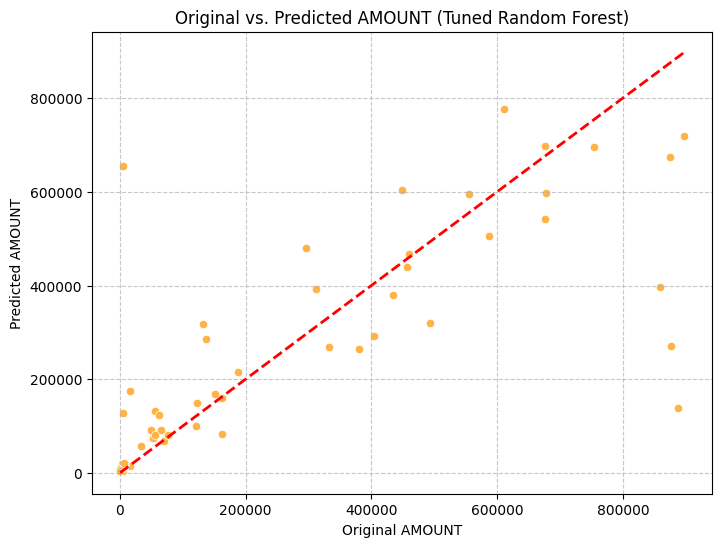

In [1027]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val_model, y=y_pred_rf_tuned, color='#FFB347')
plt.plot([y_val_model.min(), y_val_model.max()], [y_val_model.min(), y_val_model.max()], '--r', linewidth=2) # Line for perfect prediction
plt.xlabel('Original AMOUNT')
plt.ylabel('Predicted AMOUNT')
plt.title('Original vs. Predicted AMOUNT (Tuned Random Forest)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [1028]:
results_df = pd.DataFrame({
    'Original_AMOUNT': y_val_model,
    'Predicted_AMOUNT': y_pred_rf_tuned
})

results_df['Absolute_Difference'] = abs(results_df['Original_AMOUNT'] - results_df['Predicted_AMOUNT'])


# Sort by Original_AMOUNT to make it easier to compare similar values
results_df = results_df.sort_values(by='Original_AMOUNT').reset_index(drop=True)

display(results_df.head(10))

,Original_AMOUNT,Predicted_AMOUNT,Absolute_Difference
0,539.000000,8268.412282,7729.412282
1,878.000000,4764.250379,3886.250379
2,1499.000000,3508.020050,2009.020050
3,1976.000000,12762.807395,10786.807395
4,2841.000000,8621.672621,5780.672621
5,3316.000000,19386.296058,16070.296058
6,5234.000000,127455.750619,122221.750619
7,5757.000000,655772.513677,650015.513677
8,5879.750513,5100.597380,779.153133
9,5899.000000,15346.158429,9447.158429


With only ~327 rows and multiple features, the model cannot learn all interactions reliably.

It’s prone to overfitting, especially if some features are categorical with many levels (like product group, events, festivals).

Rare events (like very high sales) aren’t seen enough for the model to predict them correctly.

Daily sales are very dependent on previous days’ sales. Without lag features, the model can’t anticipate sudden spikes or drops



---



---



# Part 2

2. Create a Reusable Forecasting Function

- Accept a future calendar (with event info but no sales values).

- Automatically assign day-type groups and generate predicted sales for each date.

In [1029]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


- To predict future sales  'AMOUNT',  typically have information about the future calendar, events, and promotions, but  won't know the future 'QTY' of products sold.
- creating a new feature DataFrame by dropping the 'QTY' column from the existing X_model DataFrame. This will prepare the data for retraining the model without the 'QTY' feature.


In [1030]:
#  Create a new feature DataFrame by dropping the 'QTY' column
X_model_no_qty = X_model.drop(columns=['QTY'])

In [1031]:
# Split X_model_no_qty and y_model into training and validation sets
X_train_model_no_qty, X_val_model_no_qty, y_train_model, y_val_model = train_test_split(
    X_model_no_qty, y_model, test_size=0.2, random_state=42
)


- Random Forest Model with best HYperparameters

In [1032]:
# Initialize a RandomForestRegressor model using the best hyperparameters
rf_best_tuned_no_qty = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

In [1033]:
# Train the rf_best_tuned_no_qty model
rf_best_tuned_no_qty.fit(X_train_model_no_qty, y_train_model)

RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42)

In [1034]:
# Make predictions on the validation set
y_pred_rf_tuned_no_qty = rf_best_tuned_no_qty.predict(X_val_model_no_qty)

In [1035]:
#Calculate and print the Mean Absolute Error (MAE) and R-squared (R²) score
mae_rf_tuned_no_qty = mean_absolute_error(y_val_model, y_pred_rf_tuned_no_qty)
print(f"Validation MAE (Tuned Random Forest without QTY): {mae_rf_tuned_no_qty:.2f}")

r2_rf_tuned_no_qty = r2_score(y_val_model, y_pred_rf_tuned_no_qty)
print(f"Validation R² (Tuned Random Forest without QTY): {r2_rf_tuned_no_qty:.4f}")

Validation MAE (Tuned Random Forest without QTY): 116851.45
Validation R² (Tuned Random Forest without QTY): 0.5992


## Forecasting Function

- Create a  function predict_future_sales that accepts a **future_calendar_df** as input.



To create the predict_future_sales function as requested, defined a Python function that takes `future_calendar_df` as its sole argument. This will serve as the initial structure for the forecasting function.



In [1036]:
def predict_future_sales(future_calendar_df):
    """
    Predicts future sales based on a given calendar DataFrame.

    Args:
        future_calendar_df (pd.DataFrame): A DataFrame containing future calendar and event information.
                                          Expected columns similar to the training data, but without 'AMOUNT' and 'QTY'.

    Returns:
        pd.DataFrame: The input DataFrame with an added 'Predicted_AMOUNT' column.
    """



- convert the 'BillDate' column to datetime objects.



In [1037]:
def predict_future_sales(future_calendar_df):
    """
    Predicts future sales based on a given calendar DataFrame.

    Args:
        future_calendar_df (pd.DataFrame): A DataFrame containing future calendar and event information.
                                          Expected columns similar to the training data, but without 'AMOUNT' and 'QTY'.

    Returns:
        pd.DataFrame: The input DataFrame with an added 'Predicted_AMOUNT' column.
    """
    # 1. Convert 'BillDate' to datetime
    future_calendar_df['BillDate'] = pd.to_datetime(future_calendar_df['BillDate'], format='%d-%b-%y')

    # 2. Extract 'Day', 'Month', and 'Year'
    future_calendar_df['Day'] = future_calendar_df['BillDate'].dt.day
    future_calendar_df['Month'] = future_calendar_df['BillDate'].dt.month
    future_calendar_df['Year'] = future_calendar_df['BillDate'].dt.year

    # 3. Create 'WeekDayNum' column
    future_calendar_df['WeekDayNum'] = future_calendar_df['WeekDay'].str.split('-').str[0].astype(int)

    # 4. Create 'IsWeekend' column
    future_calendar_df['IsWeekend'] = future_calendar_df['WeekDayNum'].isin([1, 7]).astype(int)

    # 5. Drop original 'WeekDay' and 'BillDate' columns
    future_calendar_df = future_calendar_df.drop(columns=['WeekDay', 'BillDate'])

    # 6. Fill missing values
    future_calendar_df.fillna({
        'PaperAdd': 'NO',
        'StoreEvent': 'NO_Event',
        'AuspiciousDay': 'NO',
        'FestivalName': 'NO_Festival'
    }, inplace=True)

    # 7. Apply binary encoding to 'PaperAdd' and 'AuspiciousDay'
    future_calendar_df['PaperAdd'] = future_calendar_df['PaperAdd'].map({'YES': 1, 'NO': 0})
    future_calendar_df['AuspiciousDay'] = future_calendar_df['AuspiciousDay'].map({'YES': 1, 'NO': 0})

    # 8. Apply binary encoding to 'StoreEvent'
    future_calendar_df['StoreEvent'] = future_calendar_df['StoreEvent'].apply(lambda x: 0 if x == 'NO_Event' else 1)

    # 9. Apply one-hot encoding to 'ProductGroup' and 'FestivalName'
    ohe_cols = ['ProductGroup', 'FestivalName']
    future_calendar_df = pd.get_dummies(
        future_calendar_df,
        columns=ohe_cols,
        prefix=['PG', 'FN'],
        dtype=int
    )

    # 10. Ensure consistent columns with X_train_model_no_qty
    # Get the columns from the training data
    train_cols = X_train_model_no_qty.columns

    # Add missing columns to future_calendar_df and set to 0
    missing_cols = set(train_cols) - set(future_calendar_df.columns)
    for c in missing_cols:
        future_calendar_df[c] = 0

    # Remove extra columns from future_calendar_df
    extra_cols = set(future_calendar_df.columns) - set(train_cols)
    future_calendar_df = future_calendar_df.drop(columns=list(extra_cols))

    # Reorder columns to match the training data
    future_calendar_df = future_calendar_df[train_cols]

    # Make predictions
    future_calendar_df['Predicted_AMOUNT'] = rf_best_tuned_no_qty.predict(future_calendar_df)

    return future_calendar_df

**Reasoning**:
To test the forecasting function, I need to create a sample `future_calendar_df` with the specified columns and example data for future dates and events. This will simulate the input for the `predict_future_sales` function.



In [1038]:
#  Create a sample Pandas DataFrame named `future_calendar_df`
future_calendar_df = pd.DataFrame({
    'Branch': ['VenX It Solutions', 'VenX It Solutions', 'VenX It Solutions', 'VenX It Solutions'],
    'BillDate': ['15-Sep-24', '16-Sep-24', '17-Sep-24', '18-Sep-24'],
    'ProductGroup': ['Textiles', 'ReadyMade', 'Handlooms', 'Accessories '],
    'PaperAdd': ['NO', 'YES', 'NO', 'NO'],
    'AuspiciousDay': ['NO', 'NO', 'YES', 'NO'],
    'FestivalName': ['NO_Festival', 'NO_Festival', 'VINAYAKA CHAVITHI', 'NO_Festival'],
    'StoreEvent': ['NO_Event', 'UPTO 20% OFF ON HANDPICKED SAREE', 'NO_Event', 'NO_Event'],
    'WeekDay': ['1-Sunday', '2-Monday', '3-Tuesday', '4-Wednesday']
})

print("Sample future calendar DataFrame created.")
future_calendar_df.head(3)

Sample future calendar DataFrame created.


,Branch,BillDate,ProductGroup,PaperAdd,AuspiciousDay,FestivalName,StoreEvent,WeekDay
0,VenX It Solutions,15-Sep-24,Textiles,NO,NO,NO_Festival,NO_Event,1-Sunday
1,VenX It Solutions,16-Sep-24,ReadyMade,YES,NO,NO_Festival,UPTO 20% OFF ON HANDPICKED SAREE,2-Monday
2,VenX It Solutions,17-Sep-24,Handlooms,NO,YES,VINAYAKA CHAVITHI,NO_Event,3-Tuesday



- Now that the future_calendar_df is created, call the `predict_future_sales` function with it as an argument and display the resulting DataFrame including the 'Predicted_AMOUNT' column to show the predicted sales.



In [1039]:
predicted_sales_df = predict_future_sales(future_calendar_df.copy())

display(predicted_sales_df)

,PaperAdd,AuspiciousDay,StoreEvent,Day,Month,Year,WeekDayNum,IsWeekend,PG_Accessories,PG_Handlooms,PG_ReadyMade,PG_Textiles,FN_NO_Festival,FN_SANKRANTI MAJOR,FN_SRAVANAM,FN_VINAYAKA CHAVITHI,Predicted_AMOUNT
0,0,0,0,15,9,2024,1,1,0,0,0,1,1,0,0,0,249688.677482
1,1,0,1,16,9,2024,2,0,0,0,1,0,1,0,0,0,466180.472770
2,0,1,0,17,9,2024,3,0,0,1,0,0,0,0,0,1,99395.071976
3,0,0,0,18,9,2024,4,0,0,0,0,0,1,0,0,0,164863.651142
